# Unsupervised learning for data clustering

## Global settings

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [60]:
def simple_plot(df, feature, low_i=200, high_i=500): 
    # Add temperary `id` for plotting
    df['id'] = range(len(df))
    df.iloc[low_i:high_i].plot.scatter(x='id', y=feature)
    df.drop(columns=['id'], inplace=True)
    
class AnomalyPlotter():
    def __init__(self, data, true_label, predicted_label): 
        # Omit extreme data points
        data = data.loc[data['temperature'] > -50]
        # Add temperary `id` for plotting
        data['id'] = range(len(data))        
        self.data = data
        self.data_tp = data.loc[(data[true_label] == 1) & data[predicted_label] == 1]
        self.data_tn = data.loc[(data[true_label] == 0) & data[predicted_label] == 0]
        self.data_fp = data.loc[(data[true_label] == 1) & data[predicted_label] == 0]
        self.data_fn = data.loc[(data[true_label] == 0) & data[predicted_label] == 1]
        
        self.data_normal = data.loc[data[true_label] == 0]
        self.data_abnormal = data.loc[data[true_label] == 1]
        self.data_pred_normal = data.loc[data[predicted_label] == 0]
        self.data_pred_abnormal = data.loc[data[predicted_label] == 1]
        
    def plot_anomalies(self, feature, ax): 
        self.data_normal.plot.scatter(x='id', y=feature, s=4, c='green', figsize=(16, 9), alpha=0.5, ax=ax[0], label='True Normal')
        self.data_abnormal.plot.scatter(x='id', y=feature, s=4, c='red', alpha=0.5, ax=ax[0], label='True Abnormal')
        self.data_pred_normal.plot.scatter(x='id', y=feature, s=4, c='green', alpha=0.5, ax=ax[1], label='Predicted Normal')
        self.data_pred_abnormal.plot.scatter(x='id', y=feature, s=4, c='red', alpha=0.5, ax=ax[1], label='Predicted Abnormal')
        return ax
        
    def plot_corr(self, feature1, feature2, ax): 
        self.data_normal.plot.scatter(x=feature1, y=feature2, s=4, c='green', figsize=(16, 9), alpha=0.5, ax=ax[0], label='True normal')
        self.data_abnormal.plot.scatter(x=feature1, y=feature2, s=4, c='red', alpha=0.5, ax=ax[0], label='True Abnormal')
        self.data_pred_normal.plot.scatter(x=feature1, y=feature2, s=4, c='green', alpha=0.5, ax=ax[1], label='Predicted Normal')
        self.data_pred_abnormal.plot.scatter(x=feature1, y=feature2, s=4, c='red', alpha=0.5, ax=ax[1], label='Predicted Abnormal')
        return ax

        
    def plot_pred_anomalies(self, feature, ax):
        ''' Plot the predicted anomalies.
        '''
        self.data_fp.plot.scatter(x='id', y=feature, s=4, c='orange', figsize=(16, 9), alpha=0.5, ax=ax, label='False Positive')
        self.data_fn.plot.scatter(x='id', y=feature, s=4, c='red', alpha=0.5, ax=ax, label='False Negative')
        self.data_tn.plot.scatter(x='id', y=feature, s=4, c='blue', alpha=0.5, ax=ax, label='True Negative')
        self.data_tp.plot.scatter(x='id', y=feature, s=4, c='green', alpha=0.5, ax=ax, label='True Positive')
        return ax
    
    def plot_pred_corr(self, feature1, feature2, ax): 
        ''' Plot the predicted results along two dimensions
        '''
        self.data_fp.plot.scatter(x=feature1, y=feature2, s=4, c='orange', figsize=(8, 8), alpha=0.5, ax=ax, label='False Positive')
        self.data_fn.plot.scatter(x=feature1, y=feature2, s=4, c='red', alpha=0.5, ax=ax, label='False Negative')
        self.data_tn.plot.scatter(x=feature1, y=feature2, s=4, c='blue', alpha=0.5, ax=ax, label='True Negative')
        self.data_tp.plot.scatter(x=feature1, y=feature2, s=4, c='green', alpha=0.5, ax=ax, label='True Positive')
        return ax


In [61]:
DATA_PATH = "data/2010to2017nsWithoutNA.csv"

In [62]:
data = pd.read_csv(DATA_PATH)
data.head()

,time,Longitude,Latitude,botDepth,date,depth,temperature,salinity,qualityflag
0,15.0,9.65706,53.57080,12.0,20100121.0,3.0,0.0005,33.658676,0.0
1,15.0,9.65226,53.57170,11.0,20100121.0,3.0,0.0026,33.658894,0.0
2,15.0,9.64802,53.57256,13.0,20100121.0,3.0,0.0015,33.658823,0.0
3,15.0,9.64354,53.57392,12.0,20100121.0,3.0,0.0018,33.658896,0.0
4,15.0,9.63918,53.57548,13.0,20100121.0,3.0,0.0010,33.658877,0.0


## Data preprocessing

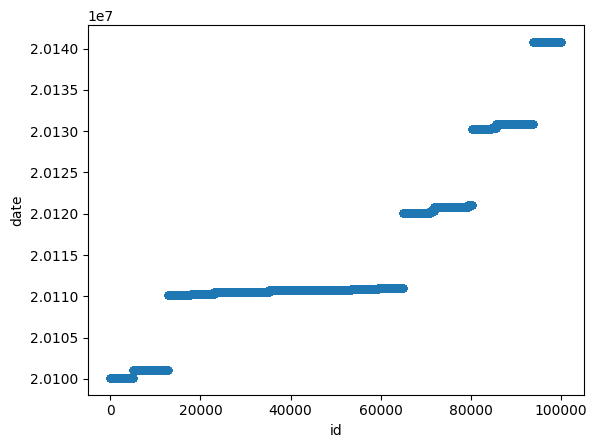

In [40]:
feature = 'date'
simple_plot(data, feature, low_i=0, high_i=100000)

In [63]:
# Get input data
input_data = data.drop(columns=['qualityflag', 'date', 'time'])
input_data.head()

,Longitude,Latitude,botDepth,depth,temperature,salinity
0,9.65706,53.57080,12.0,3.0,0.0005,33.658676
1,9.65226,53.57170,11.0,3.0,0.0026,33.658894
2,9.64802,53.57256,13.0,3.0,0.0015,33.658823
3,9.64354,53.57392,12.0,3.0,0.0018,33.658896
4,9.63918,53.57548,13.0,3.0,0.0010,33.658877


In [64]:
# Normalize input data
preprocessing.MinMaxScaler()
scaler = preprocessing.MinMaxScaler()
names = input_data.columns
d = scaler.fit_transform(input_data)
normalized_data = pd.DataFrame(d, columns=names)
normalized_data.head()

,Longitude,Latitude,botDepth,depth,temperature,salinity
0,0.026825,0.368558,0.021126,0.8,0.891841,0.938269
1,0.026812,0.368626,0.020290,0.8,0.891848,0.938276
2,0.026800,0.368690,0.021963,0.8,0.891845,0.938274
3,0.026788,0.368792,0.021126,0.8,0.891846,0.938276
4,0.026775,0.368909,0.021963,0.8,0.891843,0.938275


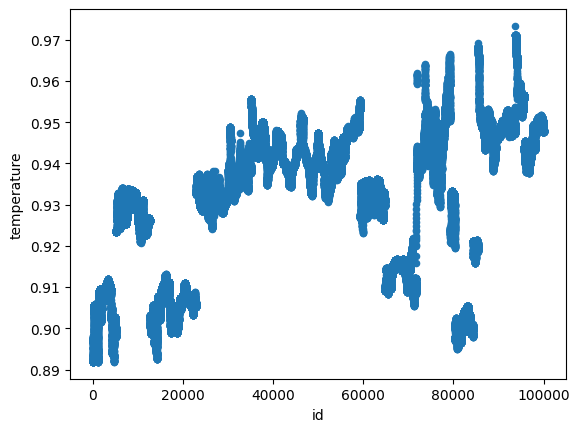

In [34]:
feature = 'temperature'
simple_plot(normalized_data, feature, low_i=0, high_i=100000)

## K-means

In [65]:
# Apply k-Means
kmean = KMeans(n_clusters=2)
kmean.fit(normalized_data)
label = kmean.predict(normalized_data)

In [66]:
data['kmeans_label'] = label
data.head()

,time,Longitude,Latitude,botDepth,date,depth,temperature,salinity,qualityflag,kmeans_label
0,15.0,9.65706,53.57080,12.0,20100121.0,3.0,0.0005,33.658676,0.0,0
1,15.0,9.65226,53.57170,11.0,20100121.0,3.0,0.0026,33.658894,0.0,0
2,15.0,9.64802,53.57256,13.0,20100121.0,3.0,0.0015,33.658823,0.0,0
3,15.0,9.64354,53.57392,12.0,20100121.0,3.0,0.0018,33.658896,0.0,0
4,15.0,9.63918,53.57548,13.0,20100121.0,3.0,0.0010,33.658877,0.0,0


In [67]:
# Number of true labels
true_0 = data[data.qualityflag==0]
true_1 = data[data.qualityflag==1]
(len(true_0), len(true_1))

(219079, 1533)

In [ ]:
# Number of predicted labels
kmeans_0 = data[data.kmeans_label==0]
kmeans_1 = data[data.kmeans_label==1]
(len(kmeans_0), len(kmeans_1))

(179708, 40904)

In [98]:
# Precision, Recall, F1 score
y_true = data['qualityflag']
y_pred = data['kmeans_label']
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
scores = np.around(np.array((precision, recall, f1)), decimals=3)

scores

array([0.022, 0.578, 0.042])

In [43]:
# silhouette_score(input_data, label)

In [82]:
# TP, TN, FN, TP
cm = confusion_matrix(y_true, y_pred)
cm

array([[179061,  40018],
       [   647,    886]])

In [83]:
TN, FP, FN, TP = cm.ravel()
(TP, FP, TN, FN)

(886, 40018, 179061, 647)

In [91]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
F1 = 2 * (PPV * TPR) / (PPV + TPR)


In [48]:
# Save predicted labels and metrics
data.to_csv('results/kmeans.csv', index=False)

In [100]:
num_d = 3
# Save the new result
# new_result = {
#     'method': 'kmeans_normalized', 
#     'TPR': round(TPR, num_d), 
#     'TNR': round(TNR, num_d), 
#     'FPR': round(FPR, num_d), 
#     'FNR': round(FNR, num_d), 
#     'Precision': round(PPV, num_d),  
#     'Recall': round(TPR, num_d)
# }

new_result = {
    'method': 'kmeans_no_time', 
    'Precision': scores[0], 
    'Recall': scores[1], 
    'F1': scores[2]
}
new_result = pd.DataFrame(new_result, index=[0])

try: 
    result_metrics = pd.read_csv('results/result_metrics.csv')
    result_metrics = pd.concat([result_metrics, new_result])
except: 
    print('Create new result file.')
    result_metrics = new_result

Create new result file.


In [101]:
result_metrics

,method,Precision,Recall,F1
0,kmeans_no_time,0.022,0.578,0.042


In [ ]:
# Save the metrics
result_metrics.to_csv('results/result_metrics.csv', index=False)

/tmp/ipykernel_311459/787277233.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['id'] = range(len(data))


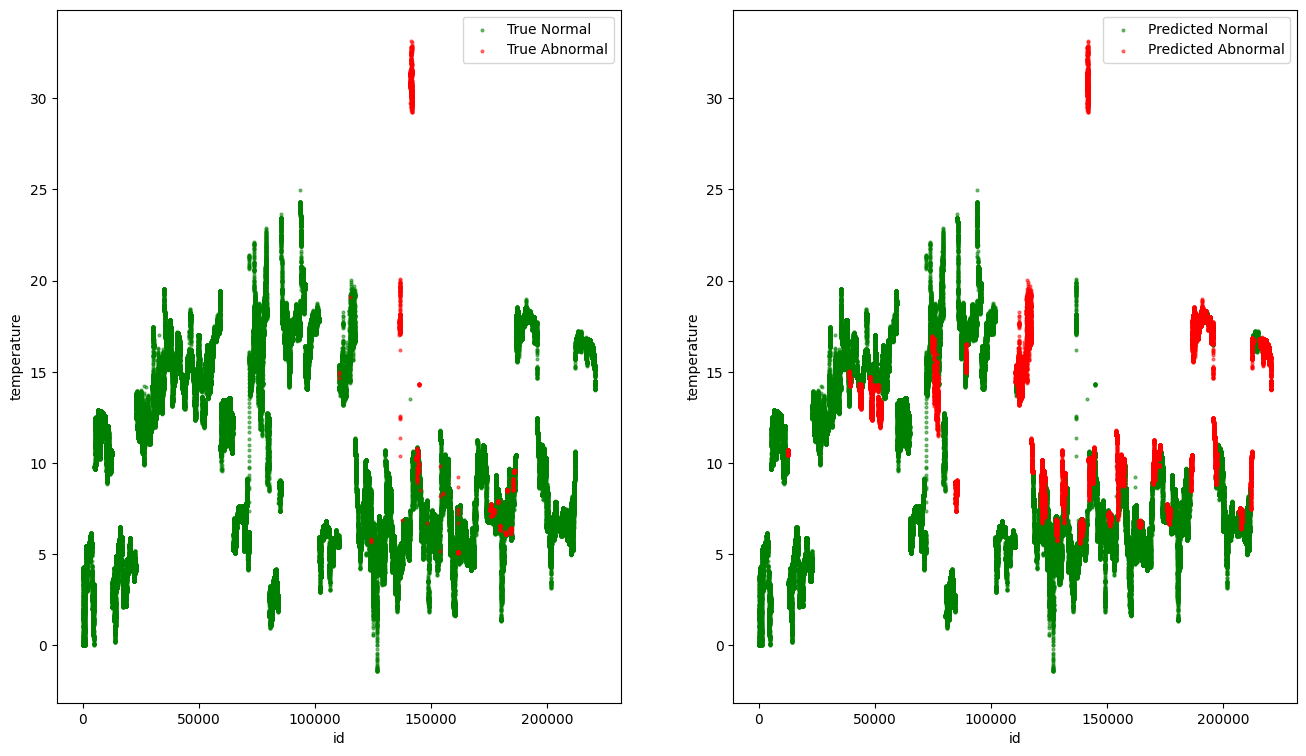

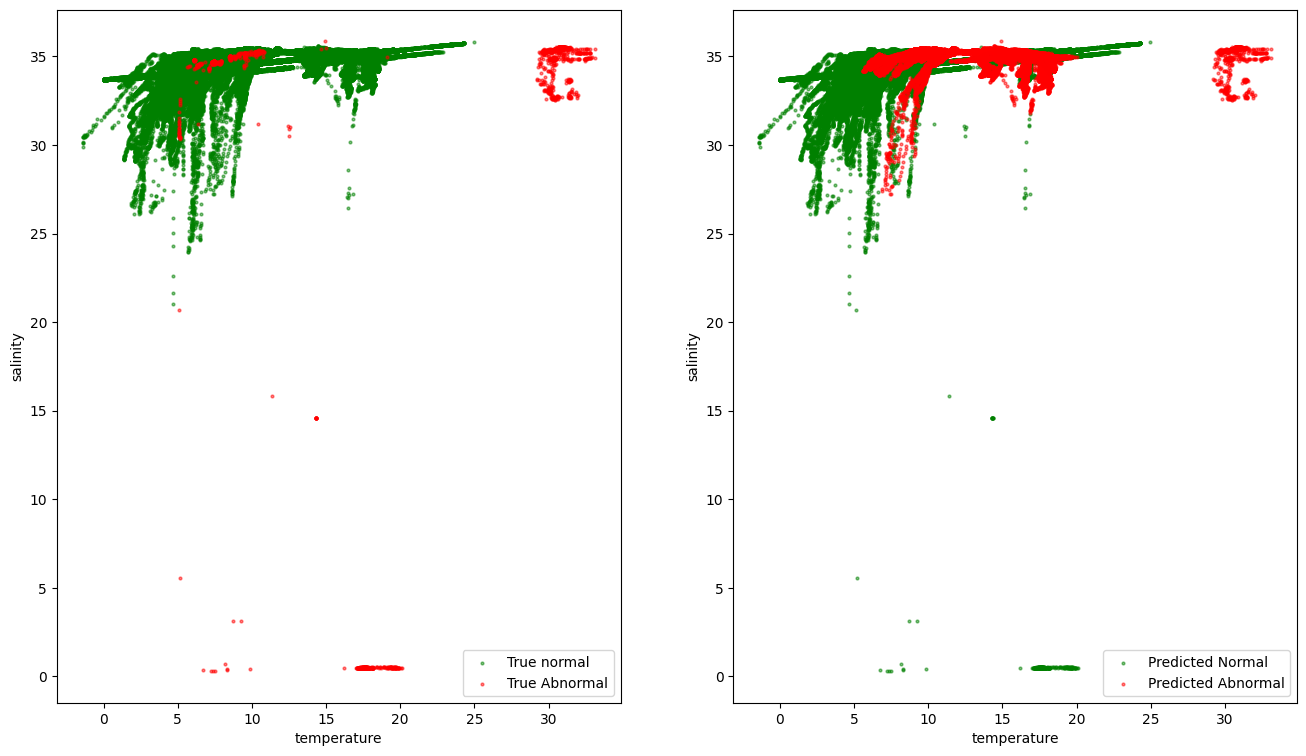

In [102]:
# Plot the true and predicted results
true_label='qualityflag'
predicted_label='kmeans_label'
plotter = AnomalyPlotter(data, true_label, predicted_label)

feature = 'temperature'
feature1 = 'temperature'
feature2 = 'salinity'

fig, ax = plt.subplots(1, 2)
plotter.plot_anomalies(feature, ax)  

fig, ax = plt.subplots(1, 2)
ax2 = plotter.plot_corr(feature1, feature2, ax)            